In [7]:

function tbf90(I01p, T, incAng, k, a, g, n, eps, dz)
    cos1 = cos(incAng / 180.0 * π)
    Jup = zeros(eltype(I01p), n + 1)
    Jd = zeros(eltype(I01p), n + 1)

    intDo = zeros(eltype(I01p), n + 1)
    intUp = zeros(eltype(I01p), n + 1)
    
    # these temperatures should be defined at the boundaries between cells
    # there are n I0 and n+1 I1 values
    for k1 in 1:n+1
        Jup[k1] = (1 - a[k1]) * T[k1] + a[k1] * (0.5 * (I01p[2*k1-1] + I01p[2*k1+1]) * g[k1] * cos1 + I01p[2*k1])
        Jd[k1] = (1 - a[k1]) * T[k1] + a[k1] * (-0.5 * (I01p[2*k1-1] + I01p[2*k1+1]) * g[k1] * cos1 + I01p[2*k1])
    end

    intDo[1] = k[1] * dz / 2
    intUp[n+1] = k[n+1] * dz / 2

    for k1 in 1:n
        intUp[n+1-k1] = intUp[n-k1+2] + 0.5 * (k[n+1-k1] + k[n+1-k1+1]) * dz
    end

    for k1 in 2:n+1
        intDo[k1] = intDo[k1-1] + 0.5 * (k[k1] + k[k1-1]) * dz
    end
    sumJD = zero(eltype(I01p))
    sumJU = zero(eltype(I01p))
    
    for i in 1:n+1
        sumJD += Jd[i] * exp(-intDo[i] / cos1) * k[i] * dz / cos1
        sumJU += Jup[i] * exp(-intUp[i] / cos1) * k[i] * dz / cos1
    end

    Tb = (1 - eps) * exp(-intUp[1] / cos1) * sumJD + sumJU + eps * exp(-intUp[1] / cos1) * T[1]
    return Tb
end

function SetEddington1D(T, k, a, g, n, eps, dz, Ts)
    Abig = zeros(eltype(T), 2*n+3, 2*n+3)
    B = zeros(eltype(T), 2*n+3)
    # dI0/dz=-k*(1-a*g)*I1      deq  
    # dI1/dz=-3*k*(1-a)*(I0-T)  deq 
    # I0,0+(2-eps)/(3*eps)*(I1,0+I1,1)=Ts bc
    # the first component of the solution is I1,1, then I0,1 and so on
    # J=(1-a)*T+a*(I0+g*I1*cos(ang))  J
    # Io,n -1/3 [I1,n+I1,n+1]= 2.7 top boundary
    # In this discretization, temperatures and scattering properties should be defined at the centers of cells
    for i in 0:n
        Abig[2*i+2, 2*i+2] = 3 * k[i+1] * (1 - a[i+1]) * dz  # equation for I1
        Abig[2*i+2, 2*i+3] = 1
        Abig[2*i+2, 2*i+1] = -1
        B[2*i+2] = 3 * k[i+1] * (1 - a[i+1]) * T[i+1] * dz

        if 2*i+3 < 2*n+3
            km = 0.5 * (k[i+1] + k[i+2])
            am = 0.5 * (a[i+1] + a[i+2])
            gm = 0.5 * (g[i+1] + g[i+2])
            Abig[2*i+3, 2*i+3] = km * (1 - am * gm) * dz # equation for I0
            Abig[2*i+3, 2*i+4] = 1
            Abig[2*i+3, 2*i+2] = -1
            B[2*i+3] = 0.0
        end
    end

    Abig[2*n+3, 2*n+2] = 1.0
    Abig[2*n+3, 2*n+3] = -1.0 / 3.0
    Abig[2*n+3, 2*n+1] = -1.0 / 3.0
    B[2*n+3] = 2.7

    Abig[1, 1] = (2 - eps) / (3 * eps)
    Abig[1, 2] = 1.0
    Abig[1, 3] = (2 - eps) / (3 * eps)
    B[1] = Ts
    return Abig, B 
end


SetEddington1D (generic function with 1 method)

In [64]:
function tbwrapper_enz(params::Array{Float64}, y::Array{Float64})
    n1=Int((size(params)[1]-4)/4)
    kext1=params[1:n1]
    kscat1=params[n1+1:2*n1]
    asym1=params[2*n1+1:3*n1]
    temp1=params[3*n1+1:4*n1+1]
    eps=params[4*n1+2]
    dz=params[4*n1+3]
    incAng=params[4*n1+4]
    n=n1-1
    temp_mid = 0.5 * (temp1[1:end-1] + temp1[2:end])
    #println("$dz $incAng $eps $n");
    A,B=SetEddington1D(temp_mid, kext1, kscat1, asym1, n, eps, dz, temp1[1]);
    I01p=A\B;
    Tb_jl=tbf90(I01p, temp1, incAng, kext1, kscat1, asym1, n, eps, dz);
    y[1]=Tb_jl;
    return nothing #, I01p
end

tbwrapper_enz (generic function with 1 method)

In [13]:
#using ReverseDiff
#using Pkg
#Pkg.add("ReverseDiff")
import PyCall
using PyCall
np=pyimport("numpy")
pushfirst!(PyVector(pyimport("sys")["path"]), "")
read_rte_data=pyimport("read_rte_data")
kext, scat, asym, temp, tb_eddgn=read_rte_data.read_data();


In [27]:
using Pkg
#Pkg.add("ForwardDiff")
Pkg.add("Enzyme")

   Resolving package versions...
   Installed Enzyme_jll ─── v0.0.128+0
   Installed EnzymeCore ─── v0.7.6
   Installed StructIO ───── v0.3.0
   Installed TimerOutputs ─ v0.5.24
   Installed GPUCompiler ── v0.26.6
   Installed Enzyme ─────── v0.12.21
   Installed ObjectFile ─── v0.4.1
    Updating `~/.julia/environments/v1.10/Project.toml`
  [7da242da] + Enzyme v0.12.21
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [7da242da] + Enzyme v0.12.21
  [f151be2c] + EnzymeCore v0.7.6
  [e2ba6199] + ExprTools v0.1.10
  [61eb1bfa] + GPUCompiler v0.26.6
  [d8793406] + ObjectFile v0.4.1
  [6c6a2e73] + Scratch v1.2.1
  [53d494c1] + StructIO v0.3.0
  [a759f4b9] + TimerOutputs v0.5.24
⌅ [7cc45869] + Enzyme_jll v0.0.128+0
        Info Packages marked with ⌅ have new versions available but compatibility constraints restrict them from upgrading. To see why use `status --outdated -m`
Precompiling project...
  ✓ Scratch
  ✓ StructIO
  ✓ ExprTools
  ✓ EnzymeCore
  ✓ Enzyme_jll
  ✓ EnzymeCore →

In [75]:
#using ReverseDiff
#using ForwardDiff
using Enzyme
tbL1=[]
tbL2=[]
gradient_Enz_L=[]
for i in 1:1001
    kext1=Float64.(kext[i,1:end])
    kscat1=Float64.(scat[i,1:end])
    asym1=Float64.(asym[i,1:end])
    temp1=Float64.(temp[i,1:end])
    eps=0.7
    dz=0.25
    incAng=53
    params=vcat(kext1, kscat1, asym1, temp1, eps, dz, incAng)
    n1=Int((size(params)[1]-4)/4)
    tbj=[0.0];
    adjtb=[1.0];
    adjparams=zeros(eltype(params),size(params)[1])
    tbwrapper(params,tbj)
    Enzyme.autodiff(Reverse,tbwrapper_enz, Duplicated(params,adjparams), Duplicated(tbj, adjtb))
    push!(tbL1,tbj[1])
    push!(tbL2,tb_eddgn[i])   
    push!(gradient_Enz_L,copy(adjparams))
end



In [42]:
println(tbL1)

Any[248.35644105574104, 219.4345864789102]


In [67]:
using PyCall
pushfirst!(PyVector(pyimport("sys")["path"]), "")
read_rte_data=pyimport("read_rte_data")
#kext, scat, asym, temp, tb_eddgn=read_rte_data.read_data();

np=pyimport("numpy")
torch_rt1=pyimport("torch_rt_grad")
n=79
kext1_torch_grad=zeros(Float32, n+1)
for i in 1:1001
    kext1=Float32.(kext[i,:])
    kscat1=Float32.(scat[i,:])
    asym1=Float32.(asym[i,:])
    temp1=Float32.(temp[i,:])
    kext1_torch_grad,kscat1_torch_grad,asym1_torch_grad=torch_rt1.torch_grad(kext1, kscat1, asym1, temp1)
end 

(324,)

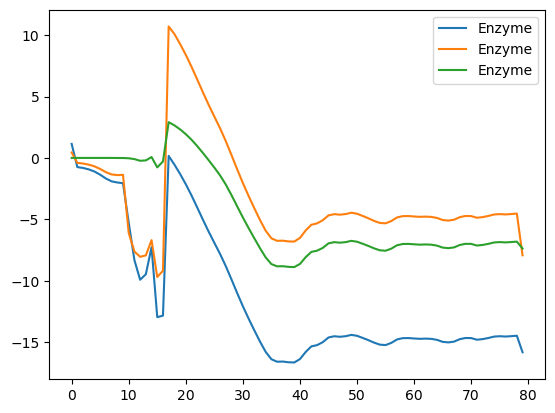

PyObject <matplotlib.legend.Legend object at 0x37470bbb0>

In [77]:
print(size(gradientL[1]))
using PyPlot
plt.close("all")
#plot(gradientL[1][1:80],label="Julia")
plot(gradient_Enz_L[1][1:80],label="Enzyme")
plot(gradient_Enz_L[2][1:80],label="Enzyme")
plot(gradient_Enz_L[3][1:80],label="Enzyme")
#plot(kext1_torch_grad,"--",label="Torch")
legend()

In [266]:
torch_rt=pyimport("torch_rt_grad")
kext1_torch_grad=zeros(Float32, n+1)
for i in 1:1
    kext1=Float32.(kext[i,:])
    kscat1=Float32.(scat[i,:])
    asym1=Float32.(asym[i,:])
    temp1=Float32.(temp[i,:])
    kext1_torch_grad,kscat1_torch_grad,asym1_torch_grad=torch_rt.torch_grad(kext1, kscat1, asym1, temp1)
end 
